# M2.1 RandomForestClassifier

This notebook contains the experiment of using a RandomForestClassifier (RFC) to classify 
tree species using the aggregated, pre-processed dataset in M1. First, a RFC with default 
hyperparameters is trained using the full imputed dataset and an undersampled version. 
Depending on the performance and the fitting time for a 5-fold cross-validation prediction 
either the full or undersampled trainingset are used to find the best hyperparameters. At the end 
the generalization performance is evaluated using the holdout-testset. 


Within the same directory as the notebook the resulting models, cross-validation and metric reports can be accessed. 

**Random Forest** (RF) is a supervised machine learning ensemble methods that is solely based on decision trees. Many decision decision trees predict the same labels, and by averaging these predictions the generalization error is increased. RF incorporates 
    (1) bagging (bootstrap aggregating), such that every learner gets a random subset (with replacement) as training data;
    (2) randomized subset of features at each decision node.
Both implemented techniques reduce overfitting in the ensemble. However, the aim for individual trees is to overfit the given subset and feature space, such that averaging the predictions lead to a better generalization error compared to individual decision trees. RF includes the hyperparameters to control the shape of individual decision trees (e.g. max leaf nodes, min samples split). The RF related hyperparameters are the number of estimators and the size of the feature subset at each decision node. 

| Avantages | Disadvantages |
|:----------:|:-------------:|
|Better generalization compared to singular decision trees|Deep trees are computational expensive|
|More robust to noise compared to singular decision trees|Many hyperparameters that need to be tuned||Possibility to extract feature importance|Feature importance interpretation is not straight forward (mean decrease in impurity is biased towards high cardinality features)|
|Non-parametric can be widely applied. For regression and classification tasks|Feature importance interpretation is not straight forward (mean decrease in impurity is biased towards high cardinality features)|
|No preprocessing needed, can handle numerical and categorical features (scikit-implementation)|
|Can be parallelized|

## libraries

In [15]:
import os 
import sys
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

sys.path.append(os.path.relpath('../shared_functions/'))
import bwi_dataset_training_funtions as sf

## initialize subdirs

In [2]:
sf.create_directory_structure()

Directory already exists: ./metrics
Directory already exists: ./model
Directory already exists: ./cross_validation


## load datasets

In [16]:
# read in datasets
data_test = pd.read_csv('../../../datasets/ml_bwi_v3_test.csv')
data_train = pd.read_csv('../../../datasets/ml_bwi_v3_train_imputed.csv', index_col=0)

## split datasets into features, targets and grouping subsets

In [18]:
# split into feautres, targets and groups
# using helper function from bwi_datset_training_functions
groups_test, features_test, targets_test = sf.split_input_data(data_test)
groups_train, features_train, targets_train = sf.split_input_data(data_train)

## set up preprocessing for all experiments

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [20]:
# set selectors
cat_selector = selector(dtype_include=object)
num_selector = selector(dtype_include=np.number)

# set transformers 
# OHE with handle_unknown='ignore' to ignore unseen categories if appearing
# in the test set (due to the train-test split and imputation)
cat_transformer = OneHotEncoder(handle_unknown='ignore') 
num_transformer = StandardScaler()

# create ColumnTransformer 
preprocessor = ColumnTransformer(
    [
        ('num', num_transformer, num_selector),
        ('cat', cat_transformer, cat_selector)
    ]
)


## Comparison RF with default parameters for full and an undersampled training set 

### RF with default hyperparameters - undersampled dataset with equal class distribution

In [21]:
# Random undersampling: 
# All classes are reduced to the size of the smallest class
u_features_train, u_targets_train, u_groups_train = sf.random_undersample(features_train,
                                                        targets_train,
                                                        groups_train,
                                                        random_state=42)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# In the undersampled all class equally balanced -> no class weight needed here
rf_u = RandomForestClassifier(random_state=42)

default_rf_pipe_u = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('classifier', rf_u)
    ]
)

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedGroupKFold

cv = StratifiedGroupKFold(n_splits=3)
default_rf_u_preds = cross_val_predict(default_rf_pipe_u,
                             u_features_train,
                             u_targets_train,
                             groups=u_groups_train['Tnr'],
                             cv=cv,
                             n_jobs=-1)

              precision    recall  f1-score   support

       Beech       0.60      0.59      0.60      1938
       Birch       0.64      0.67      0.65      1938
 Douglas fir       0.70      0.56      0.62      1938
         Fir       0.66      0.74      0.70      1938
       Larch       0.54      0.45      0.49      1938
      Maples       0.55      0.28      0.37      1938
        Oaks       0.57      0.62      0.60      1938
        Pine       0.58      0.70      0.64      1938
      Spruce       0.45      0.64      0.53      1938

    accuracy                           0.58     17442
   macro avg       0.59      0.58      0.58     17442
weighted avg       0.59      0.58      0.58     17442



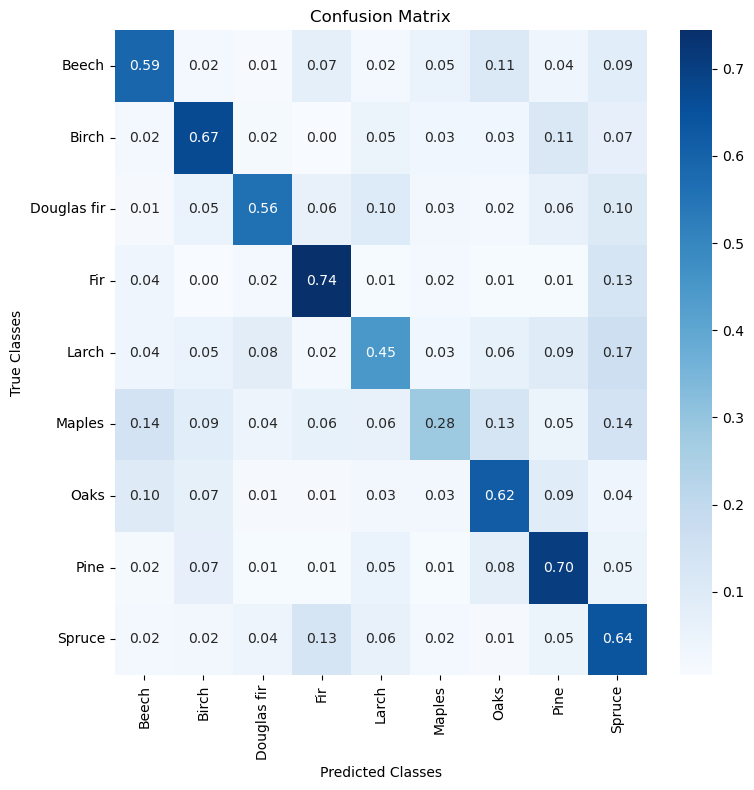

In [22]:
sf.compute_and_return_metrics(u_targets_train, default_rf_u_preds,
                              'default_rf_u_cv')

### RF with default hyperparameters - (full) imputed dataset with class balance set 

In [ ]:
# class weights PER BAG
rf = RandomForestClassifier(random_state=42, class_weight='balanced_subsample') 

default_rf_pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('classifier', rf)
    ]
)

In [27]:
cv = StratifiedGroupKFold(n_splits=3)
default_rf_preds = cross_val_predict(default_rf_pipe,
                             features_train,
                             targets_train,
                             groups=groups_train['Tnr'],
                             cv=cv,
                             n_jobs=-1)

              precision    recall  f1-score   support

       Beech       0.78      0.73      0.75     22141
       Birch       0.86      0.33      0.48      3771
 Douglas fir       0.79      0.18      0.30      2441
         Fir       0.68      0.11      0.19      2818
       Larch       0.62      0.02      0.03      2942
      Maples       0.27      0.01      0.03      1938
        Oaks       0.79      0.56      0.66     11752
        Pine       0.80      0.86      0.83     36580
      Spruce       0.76      0.94      0.84     53502

    accuracy                           0.77    137885
   macro avg       0.71      0.42      0.46    137885
weighted avg       0.77      0.77      0.75    137885



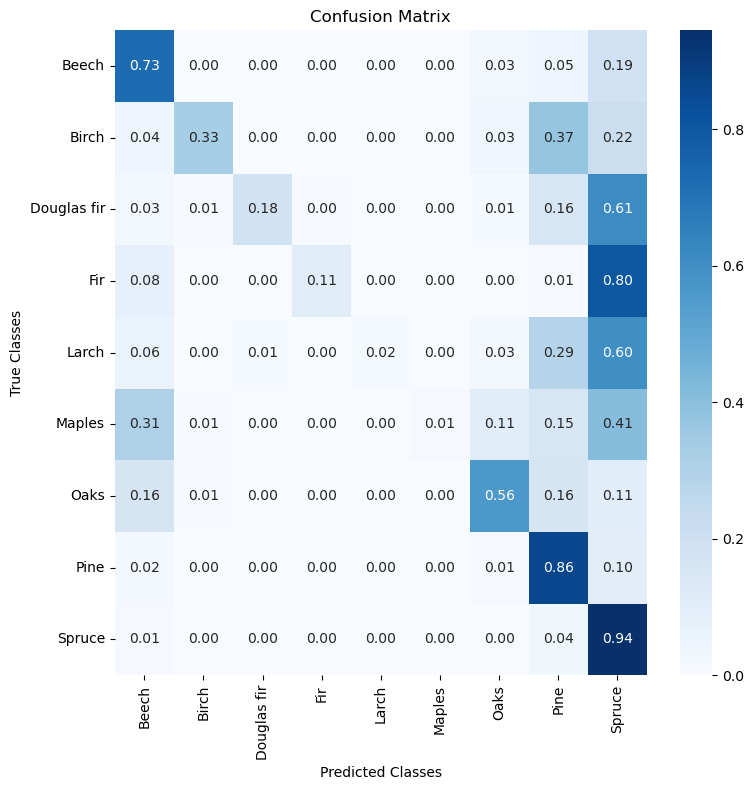

In [28]:
sf.compute_and_return_metrics(targets_train, default_rf_preds,
                              'default_rf_cv')

## RandomizedSearch with undersampled training set 

Both default RF-Classifiers have problems classifying all classes equally. Both classifiers focus on the majority class spruce. Eventhough the respective balancing strategies are used. In the following we pick the undersampled dataset and perform a randomized hyperparameter search. Not only because the performance with the default RandomForestClassifier was better but because the smaller dataset allows to test more hyperparameter combinations. 

In [35]:
from sklearn.model_selection import RandomizedSearchCV

In [49]:
# max_depth as default -> we tune depth with max_leaf nodes
rf_rs = RandomForestClassifier(random_state=42,
                               oob_score=True,
                               max_depth=None) 

rsearch_rf_u_pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('classifier', rf_rs)
    ]
)

In [274]:
# set up parameter distributions 
param_distributions = {
    'classifier__n_estimators': np.arange(100, 800, 100), 
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__min_samples_split': [*np.arange(2, 50, 10), *np.arange(0.1, 1, 0.1)], 
    'classifier__min_samples_leaf': [*np.arange(1, 50, 10), *np.arange(0.1, 1, 0.1)], 
    'classifier__max_features': [None, 'sqrt', 'log2'] + list(np.arange(1, 20, 5)), 
    'classifier__max_leaf_nodes': [None] + [2**i for i in range(6, 15)] 
}

In [ ]:
cv = StratifiedGroupKFold(n_splits=5)
rsearch_rf_u = RandomizedSearchCV(
    rsearch_rf_u_pipe,
    param_distributions=param_distributions,
    cv=cv, 
    n_iter=200, 
    random_state=42,
    scoring=['balanced_accuracy',
             'f1_macro',
             'f1_weighted', 
             'recall_weighted',
             'precision_macro',
             'precision_weighted'],
    refit='f1_macro',
    n_jobs=-1, # all
)

In [276]:
rsearch_rf_u.fit(u_features_train, u_targets_train, groups=u_groups_train['Tnr'])


c:\Users\davha\anaconda3\envs\machine_learning_preprocessing\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=StratifiedGroupKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000002783C2140E0>),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               <sklearn.compose._column_transfor...
                                                                          np.float64(0.30000000000000004),
                                                                          np.float64(0.4),
                                                                          np.float64(0.5),
                                                                          np.float64(0.6),
                                                                          np.float64(0.7000000000000001),
                                                                          np.float64(0.8),
                                                                          np.float64(0.9)],
                                        'classifier__n_estimators': array([100, 200, 300, 400, 500, 600, 700])},
                   random_state=42, refit='f1_macro',
                   scoring=['balanced_accuracy', 'f1_macro', 'f1_weighted',
                            'recall_weighted', 'precision_macro',
                            'precision_weighted'])

In [280]:
import joblib 
joblib.dump(rsearch_rf_u, './model/rsearch_rf_u.joblib')

['./model/rsearch_rf_u.joblib']

In [282]:
rsearch_rf_u_cv = pd.DataFrame(rsearch_rf_u.cv_results_)
rsearch_rf_u_cv.to_csv('./cross_validation/rsearch_rf_u_cv.csv')

In [284]:
rsearch_rf_u_cv.sort_values(by='mean_test_f1_macro', ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,param_classifier__min_samples_split,param_classifier__min_samples_leaf,param_classifier__max_leaf_nodes,param_classifier__max_features,param_classifier__criterion,...,std_test_precision_macro,rank_test_precision_macro,split0_test_precision_weighted,split1_test_precision_weighted,split2_test_precision_weighted,split3_test_precision_weighted,split4_test_precision_weighted,mean_test_precision_weighted,std_test_precision_weighted,rank_test_precision_weighted
18,414.191453,3.542894,0.574286,0.030630,400,2.0,11.0,1024,None,log_loss,...,0.007686,1,0.668458,0.652766,0.657311,0.645072,0.652760,0.655273,0.007677,1
95,535.458006,0.753815,0.387797,0.018188,700,22.0,21.0,2048,None,entropy,...,0.008170,2,0.632940,0.617602,0.622627,0.607755,0.622107,0.620606,0.008156,2
93,189.927154,1.123386,0.520090,0.025588,400,32.0,31.0,16384,None,gini,...,0.005226,4,0.595816,0.596685,0.602103,0.587375,0.600975,0.596591,0.005199,4
150,8.701384,0.337893,0.352987,0.024725,100,12.0,1.0,2048,sqrt,gini,...,0.009991,3,0.588717,0.587170,0.596240,0.602764,0.614366,0.597851,0.009970,3
123,30.717729,1.067249,0.434890,0.019265,200,32.0,11.0,1024,16,entropy,...,0.005903,6,0.588323,0.580778,0.589496,0.593845,0.598350,0.590159,0.005874,6
28,220.358607,5.630429,0.543850,0.047964,400,2.0,1.0,128,None,gini,...,0.006706,7,0.584260,0.590972,0.600139,0.580534,0.590203,0.589222,0.006683,7
7,59.225131,1.272929,1.863646,0.255845,700,2.0,1.0,None,6,gini,...,0.012831,5,0.577943,0.589351,0.588606,0.604218,0.614346,0.594893,0.012829,5
175,35.912626,1.044928,0.511548,0.031547,300,22.0,1.0,16384,sqrt,log_loss,...,0.016438,8,0.578483,0.568303,0.576125,0.606147,0.608026,0.587417,0.016421,8
109,175.318276,1.108804,0.386809,0.023574,200,32.0,1.0,128,None,entropy,...,0.005613,9,0.587546,0.577135,0.577371,0.570001,0.579140,0.578239,0.005608,9
107,97.571745,2.761166,0.956999,0.129972,700,22.0,21.0,512,16,entropy,...,0.005268,10,0.567316,0.567470,0.565632,0.575095,0.579162,0.570935,0.005258,10


              precision    recall  f1-score   support

       Beech       0.66      0.60      0.63      1938
       Birch       0.79      0.76      0.78      1938
 Douglas fir       0.68      0.61      0.64      1938
         Fir       0.67      0.76      0.71      1938
       Larch       0.61      0.59      0.60      1938
      Maples       0.56      0.44      0.50      1938
        Oaks       0.75      0.68      0.71      1938
        Pine       0.66      0.75      0.70      1938
      Spruce       0.50      0.65      0.56      1938

    accuracy                           0.65     17442
   macro avg       0.65      0.65      0.65     17442
weighted avg       0.65      0.65      0.65     17442



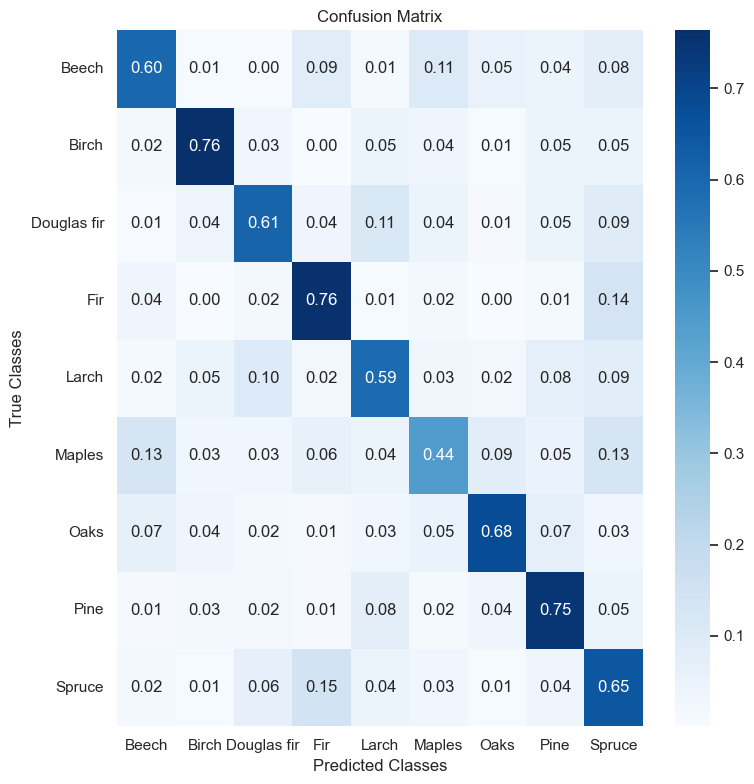

In [286]:
sf.compute_and_return_metrics(u_targets_train,
                              rsearch_rf_u_preds,
                              'rsearch_rf_u_cv')

## Final evaluation with the holdout testset 

In [5]:
model = joblib.load('./model/rsearch_rf_u.joblib')

In [6]:
model.best_params_

{'classifier__n_estimators': np.int64(400),
 'classifier__min_samples_split': np.int64(2),
 'classifier__min_samples_leaf': np.int64(11),
 'classifier__max_leaf_nodes': 1024,
 'classifier__max_features': None,
 'classifier__criterion': 'log_loss'}

In [7]:
cv_results = pd.read_csv('./cross_validation/rsearch_rf_u_cv.csv', index_col=0)

In [14]:
cv_results.sort_values(by='mean_test_f1_macro', ascending=False).head(5).filter(regex='param|mean_test_f1_macro').to_clipboard()

In [299]:
preds_test = rsearch_rf_u.predict(features_test)

              precision    recall  f1-score   support

       Beech       0.88      0.70      0.78      3397
       Birch       0.69      0.68      0.68       281
 Douglas fir       0.29      0.67      0.40       358
         Fir       0.18      0.85      0.30       489
       Larch       0.21      0.60      0.31       392
      Maples       0.17      0.53      0.26       243
        Oaks       0.78      0.77      0.77      1323
        Pine       0.85      0.60      0.70      2848
      Spruce       0.90      0.66      0.76      7433

    accuracy                           0.67     16764
   macro avg       0.55      0.67      0.55     16764
weighted avg       0.81      0.67      0.72     16764



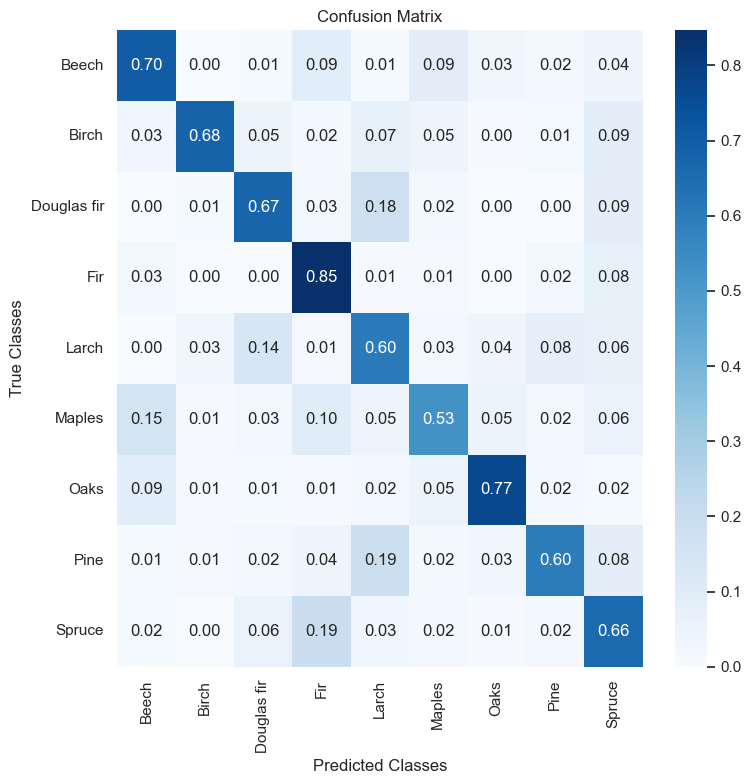

In [305]:
sf.compute_and_return_metrics(targets_test,
                              preds_test,
                              file_name='rsearch_rf_u_final_test')

## Visualizations (full) imputed dataset and undersampled dataset 

In [6]:
targets_train_counts = pd.DataFrame(targets_train.value_counts())
targets_train_counts['normalized'] = targets_train_counts/targets_train_counts.sum()
targets_train_counts['normalized'] = targets_train_counts['normalized'].round(2)
targets_train_counts['dataset'] = 'full-imputed'

u_targets_train_counts = pd.DataFrame(u_targets_train.value_counts())
u_targets_train_counts['normalized'] = u_targets_train_counts/u_targets_train_counts.sum()
u_targets_train_counts['normalized'] = u_targets_train_counts['normalized'].round(2)
u_targets_train_counts['dataset'] = 'undersampled'

targets_test_counts = pd.DataFrame(targets_test.value_counts())
targets_test_counts['normalized'] = targets_test_counts/targets_test_counts.sum()
targets_test_counts['normalized'] = targets_test_counts['normalized'].round(2)
targets_test_counts['dataset'] = 'test'

df_train_targets = pd.concat([targets_train_counts, u_targets_train_counts, targets_test_counts], axis=0)

In [11]:
df_train_targets_pivot = df_train_targets.pivot_table(index='Ba', columns='dataset', values='count', fill_value=0)
df_train_targets_pivot.to_clipboard()

In [7]:
palette = sns.color_palette(["#FF5733", "#33FF57", "#3357FF"])

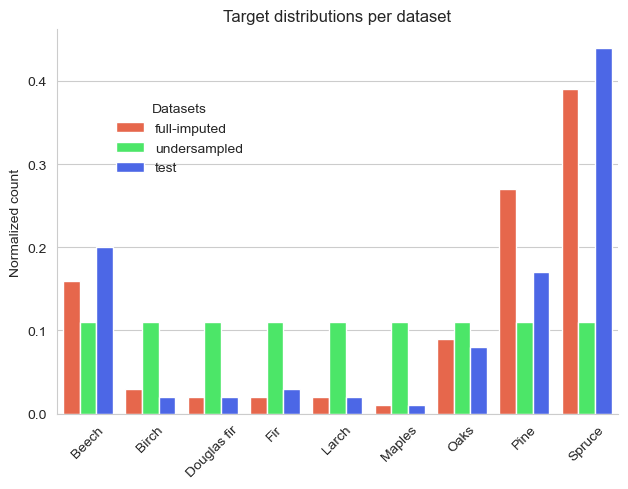

In [8]:
sns.set_style("whitegrid")

g = sns.catplot(data=df_train_targets.sort_index(),
                x=df_train_targets.sort_index().index,
                y='normalized',
                hue='dataset',
                kind='bar',
                palette=palette)
g._legend.set_title('Datasets')
g.set_ylabels('Normalized count')
g.set_xlabels('')
g.set_xticklabels(rotation=45)
g.set_titles('Target distributions per dataset')
plt.title('Target distributions per dataset')
g.legend.set_bbox_to_anchor((0.4, 0.7))
plt.tight_layout()
plt.show()